In [1]:
!pip install natsort

In [5]:
import sklearn
import tensorflow as tf
import scipy.io
import numpy as np
import os
import natsort

In [6]:
!ls ..

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
DATAPATH = '/content/drive/Shareddrives/BCI_Project/bcidata_new/'

In [11]:
files = natsort.natsorted(os.listdir(DATAPATH))

In [12]:
erp_data = [f for f in files if "ERP" in f]
mi_data = [f for f in files if "MI" in f]
ssvep_data = [f for f in files if "SSVEP" in f]
#################################################
train_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "train" in erp_data[i]]
test_data = [(erp_data[i], mi_data[i], ssvep_data[i]) for i in range(len(erp_data)) if "test" in erp_data[i]]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def get_data_splits(files, mode):
  full_erp_x = []
  full_mi_x = []
  full_ssvep_x = []

  full_erp_y = []
  full_mi_y = []
  full_ssvep_y = []

  for data in files:
    erp_file, mi_file, ssvep_file = data

    erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
    erp_x = erp_mat['save_erp_' + mode]['x'][0][0].T
    erp_y = erp_mat['save_erp_' + mode]['y'][0][0].T
    full_erp_x.append(erp_x)
    full_erp_y.append(erp_y)

    mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
    mi_x = mi_mat['save_mi_' + mode]['x'][0][0].T
    mi_y = mi_mat['save_mi_' + mode]['y'][0][0].T
    full_mi_x.append(mi_x)
    full_mi_y.append(mi_y)

    ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
    ssvep_x = ssvep_mat['save_ssvep_' + mode]['x'][0][0].T
    ssvep_y = ssvep_mat['save_ssvep_' + mode]['y'][0][0].T
    full_ssvep_x.append(ssvep_x)
    full_ssvep_y.append(ssvep_y)

  full_erp_x = np.concatenate(full_erp_x, axis=0)
  full_erp_y = np.concatenate(full_erp_y, axis=0)
  full_erp_scaled = StandardScaler().fit_transform(full_erp_x)
  pca = PCA(n_components=20)
  full_erp_x = pca.fit_transform(full_erp_scaled)

  full_mi_x = np.concatenate(full_mi_x, axis=0)
  full_mi_y = np.concatenate(full_mi_y, axis=0)
  full_mi_x = StandardScaler().fit_transform(full_mi_x)

  full_ssvep_x = np.concatenate(full_ssvep_x, axis=0)
  full_ssvep_y = np.concatenate(full_ssvep_y, axis=0)
  full_ssvep_x = StandardScaler().fit_transform(full_ssvep_x)
  return [(full_erp_x, full_erp_y), (full_mi_x, full_mi_y), (full_ssvep_x, full_ssvep_y)]

(erp_tr_x, erp_tr_y), (mi_tr_x, mi_tr_y), (ssvep_tr_x, ssvep_tr_y) = get_data_splits(train_data, 'tr')
(erp_te_x, erp_te_y), (mi_te_x, mi_te_y), (ssvep_te_x, ssvep_te_y) = get_data_splits(test_data, 'te')

In [14]:
def padding(x, y, paradigm, target_dim_x=32, target_dim_y=8):
  if paradigm == "ERP":
    padding_x = np.zeros((x.shape[0], target_dim_x - x.shape[1]))
    padding_y = np.zeros((y.shape[0], target_dim_y - y.shape[1]))
    padded_x = np.concatenate([x, padding_x], axis=1)
    padded_y = np.concatenate([y, padding_y], axis=1)
  elif paradigm == "MI":
    padding_x_l = np.zeros((x.shape[0], 20))
    padding_x_r = np.zeros((x.shape[0], 4))
    padding_y_u = np.zeros((y.shape[0], 2))
    padding_y_d = np.zeros((y.shape[0], 4))
    padded_x = np.concatenate([padding_x_l, x, padding_x_r], axis=1)
    padded_y = np.concatenate([padding_y_u, y, padding_y_d], axis=1)
  elif paradigm == "SSVEP":
    padding_x = np.zeros((x.shape[0], target_dim_x - x.shape[1]))
    padding_y = np.zeros((y.shape[0], target_dim_y - y.shape[1]))
    padded_x = np.concatenate([padding_x, x], axis=1)
    padded_y = np.concatenate([padding_y, y], axis=1)
  else:
    print("Unknown paradigm")
    return None
  return padded_x, padded_y

In [15]:
# Training data
padded_erp_x_tr, padded_erp_y_tr = padding(erp_tr_x, erp_tr_y, "ERP")
padded_mi_x_tr, padded_mi_y_tr = padding(mi_tr_x, mi_tr_y, "MI")
padded_ssvep_x_tr, padded_ssvep_y_tr = padding(ssvep_tr_x, ssvep_tr_y, "SSVEP")

# Testing data
padded_erp_x_te, padded_erp_y_te = padding(erp_te_x, erp_te_y, "ERP")
padded_mi_x_te, padded_mi_y_te = padding(mi_te_x, mi_te_y, "MI")
padded_ssvep_x_te, padded_ssvep_y_te = padding(ssvep_te_x, ssvep_te_y, "SSVEP")

In [16]:
X_tr = np.concatenate([padded_erp_x_tr, padded_mi_x_tr, padded_ssvep_x_tr], axis=0)
Y_tr = np.concatenate([padded_erp_y_tr, padded_mi_y_tr, padded_ssvep_y_tr], axis=0)
Y_tr_idx = [np.argmax(y) for y in Y_tr]

X_te = np.concatenate([padded_erp_x_te, padded_mi_x_te, padded_ssvep_x_te], axis=0)
Y_te = np.concatenate([padded_erp_y_te, padded_mi_y_te, padded_ssvep_y_te], axis=0)
Y_te_idx = [np.argmax(y) for y in Y_te]

In [17]:
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.svm import SVC
from numpy import arange
from sklearn.neighbors import KNeighborsClassifier

cv = KFold(n_splits=10, random_state=1, shuffle=True)

NCC_params = {'metric' : ['euclidean', 'manhattan'],
              'shrink_threshold' : arange(0, 1.0, 0.1)}

ncc_grid = GridSearchCV(NearestCentroid(), NCC_params, scoring='accuracy',
                        cv=cv)

LDA_params = {'solver' : ['lsqr', 'eigen'],
              'shrinkage' : arange(0, 1.0, 0.1)}

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), LDA_params,
                        scoring='accuracy', cv=cv)

SVC_params = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto']}
svc_grid = GridSearchCV(SVC(), SVC_params,
                        scoring='accuracy', cv=cv, verbose=3, n_jobs=4)

knn_params = {
    'n_neighbors' : [3, 5, 11, 19],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
                  KNeighborsClassifier(),
                  knn_params,
                  verbose = 1, 
                  cv = cv, 
                  n_jobs = -1,
                  scoring = 'accuracy', 
                  )


In [ ]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

# ncc_grid.fit(X_tr, Y_tr_idx) 
# ncc_cf = ncc_grid.best_estimator_
# print('NCC Score: ', round(accuracy_score(ncc_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

# lda_grid.fit(X_tr, Y_tr_idx)
# lda_cf = lda_grid.best_estimator_
# print('LDA Score: ', round(accuracy_score(lda_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

# svc_grid.fit(X_tr, Y_tr_idx)
# svc_cf = svc_grid.best_estimator_
# print('SVC Score: ', round(accuracy_score(svc_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

knn_grid.fit(X_tr, Y_tr_idx)
knn_cf = knn_grid.best_estimator_
print('KNN Score: ', round(accuracy_score(knn_cf.predict(X_te), Y_te_idx) * 100, 2).astype(str) + '%')

print('Best params for KNN ', knn_grid.best_params_)

print('Best score for KNN ', knn_grid.best_score_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.2min finished


KNN Score:  85.91%
Best params for KNN  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best score for KNN  0.8567283950617284


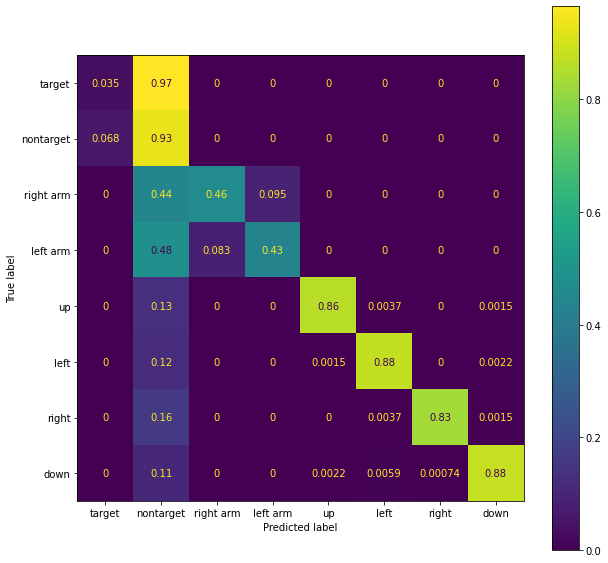

In [ ]:
# LDA Confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
labels = ["target", "nontarget", "right arm", "left arm", "up", "left", "right", "down"]
model = lda_cf
fig, ax = plt.subplots(figsize=(10, 10))
ax.title
Y_pred = model.predict(X_te)
plot_confusion_matrix(model, X_te, Y_te_idx, normalize="true", ax=ax, display_labels=labels)

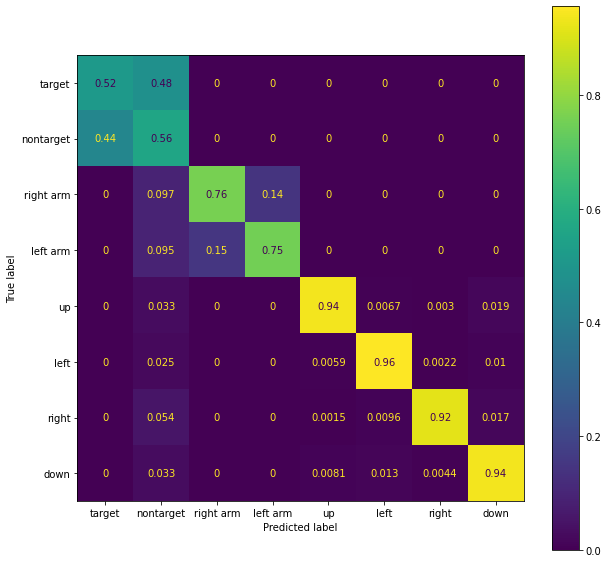

In [ ]:
# NCC confusion matrix
model = ncc_cf
fig, ax = plt.subplots(figsize=(10, 10))
ax.title
Y_pred = model.predict(X_te)
plot_confusion_matrix(model, X_te, Y_te_idx, normalize="true", ax=ax, display_labels=labels)

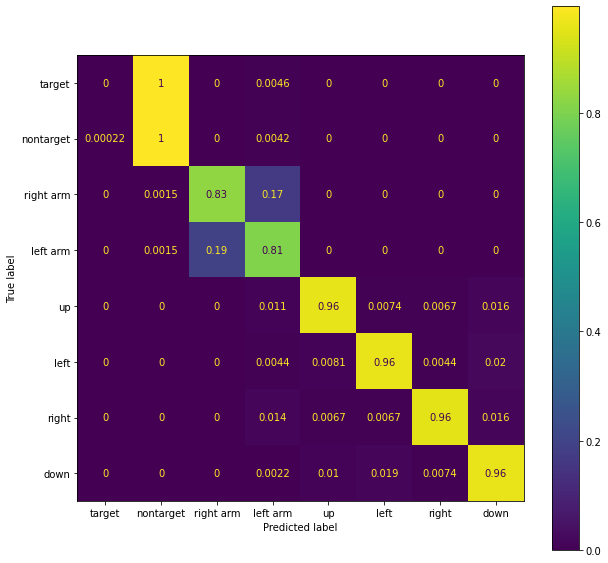

In [ ]:
# SVC confusion matrix
model = svc_cf
fig, ax = plt.subplots(figsize=(10, 10))
ax.title
Y_pred = model.predict(X_te)
plot_confusion_matrix(model, X_te, Y_te_idx, normalize="true", ax=ax, display_labels=labels)

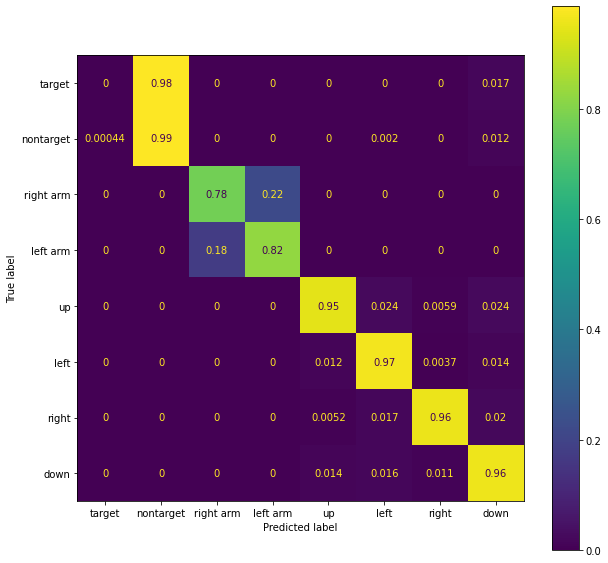

In [ ]:
# KNN confusion matrix
model = knn_cf
fig, ax = plt.subplots(figsize=(10, 10))
ax.title
Y_pred = model.predict(X_te)
plot_confusion_matrix(model, X_te, Y_te_idx, normalize="true", ax=ax, display_labels=labels)

### OLD CODE

In [ ]:
def padd_zeros_x(arr, target_dim=33):
  target_dim = 33
  diff = target_dim - arr.shape[0]
  if diff > 0:
    padding = np.zeros((diff, arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  return padded

def padd_zeros_x_alt(arr, paradigm):
  if paradigm == "ERP":
    padding = np.zeros((57 - arr.shape[0], arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  elif paradigm == "MI":
    padding_left = np.zeros((33, arr.shape[1]))
    padding_right = np.zeros((16, arr.shape[1]))
    padded = np.concatenate([padding_left, arr, padding_right],
                            axis=0)
  elif paradigm == "SSVEP":
    padding = np.zeros((57 - arr.shape[0], arr.shape[1]))
    padded = np.concatenate([padding, arr], axis=0)
  else:
    print("Unknown paradigm")
    return None
  return padded

def padd_zeros_y(arr, paradigm):
  if paradigm == "ERP":
    padding = np.zeros((6, arr.shape[1]))
    padded = np.concatenate([arr, padding], axis=0)
  elif paradigm == "MI":
    padding_up = np.zeros((2, arr.shape[1]))
    padding_down = np.zeros((4, arr.shape[1]))
    padded = np.concatenate([padding_up, arr, padding_down],
                            axis=0)
  elif paradigm == "SSVEP":
    padding = np.zeros((4, arr.shape[1]))
    padded = np.concatenate([padding, arr], axis=0)
  else:
    print("Unknown paradigm")
    return None
  return padded

In [ ]:
# Training data
train_x = []
train_y = []
for data in train_data:
  erp_file, mi_file, ssvep_file = data

  erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
  # erp_x = erp_mat['save_erp_tr']['x'][0][0]
  erp_x = padd_zeros_x_alt(erp_mat['save_erp_tr']['x'][0][0], "ERP")
  erp_y = padd_zeros_y(erp_mat['save_erp_tr']['y'][0][0], "ERP")

  mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
  # mi_x = padd_zeros_x(mi_mat['save_mi_tr']['x'][0][0])
  mi_x = padd_zeros_x_alt(mi_mat['save_mi_tr']['x'][0][0], "MI")
  mi_y = padd_zeros_y(mi_mat['save_mi_tr']['y'][0][0], "MI")

  ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
  # ssvep_x = padd_zeros_x(ssvep_mat['save_ssvep_tr']['x'][0][0])
  ssvep_x = padd_zeros_x_alt(ssvep_mat['save_ssvep_tr']['x'][0][0], "SSVEP")
  ssvep_y = padd_zeros_y(ssvep_mat['save_ssvep_tr']['y'][0][0], "SSVEP")

  X = np.concatenate([erp_x, mi_x, ssvep_x], axis=1)
  Y = np.concatenate([erp_y, mi_y, ssvep_y], axis=1)

  train_x.append(X)
  train_y.append(Y)

# Testing data
test_x = []
test_y = []
for data in test_data:
  erp_file, mi_file, ssvep_file = data

  erp_mat = scipy.io.loadmat(DATAPATH + erp_file)
  # erp_x = erp_mat['save_erp_te']['x'][0][0]
  erp_x = padd_zeros_x_alt(erp_mat['save_erp_te']['x'][0][0], "ERP")
  erp_y = padd_zeros_y(erp_mat['save_erp_te']['y'][0][0], "ERP")

  mi_mat = scipy.io.loadmat(DATAPATH + mi_file)
  # mi_x = padd_zeros_x(mi_mat['save_mi_te']['x'][0][0])
  mi_x = padd_zeros_x_alt(mi_mat['save_mi_te']['x'][0][0], "MI")
  mi_y = padd_zeros_y(mi_mat['save_mi_te']['y'][0][0], "MI")

  ssvep_mat = scipy.io.loadmat(DATAPATH + ssvep_file)
  # ssvep_x = padd_zeros_x(ssvep_mat['save_ssvep_te']['x'][0][0])
  ssvep_x = padd_zeros_x_alt(ssvep_mat['save_ssvep_te']['x'][0][0], "SSVEP")
  ssvep_y = padd_zeros_y(ssvep_mat['save_ssvep_te']['y'][0][0], "SSVEP")

  X = np.concatenate([erp_x, mi_x, ssvep_x], axis=1)
  Y = np.concatenate([erp_y, mi_y, ssvep_y], axis=1)

  test_x.append(X)
  test_y.append(Y)

In [ ]:
X_tr = np.concatenate(train_x, axis=1).T
Y_tr = np.concatenate(train_y, axis=1).T
Y_tr_idx = [np.argmax(el) for el in Y_tr]

X_te = np.concatenate(test_x, axis=1).T
Y_te = np.concatenate(test_y, axis=1).T
Y_te_idx = [np.argmax(el) for el in Y_te]

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

X_tr_scaled = rob_scaler.fit_transform(X_tr)
X_te_scaled = rob_scaler.fit_transform(X_te)

In [ ]:
from sklearn.model_selection import cross_val_score

ncc_grid.fit(X_tr_scaled, Y_tr_idx) 
lda_grid.fit(X_tr_scaled, Y_tr_idx)
svc_grid.fit(X_tr_scaled, Y_tr_idx)

lda_cf = lda_grid.best_estimator_
ncc_cf = ncc_grid.best_estimator_
svc_cf = svc_grid.best_estimator_

lda_score = cross_val_score(lda_cf, X_tr_scaled, Y_tr, cv=10)
print('LDA Cross Validation Score: ', round(lda_score.mean() * 100, 2).astype(str) + '%')


ncc_score = cross_val_score(ncc_cf, X_tr_scaled, Y_tr, cv=10)
print('NCC Cross Validation Score', round(ncc_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc_cf, X_tr_scaled, Y_tr, cv=10)
print('SVC Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

In [ ]:
train_size = len(X_tr_scaled)
y_vector = np.concatenate(train_y, axis=1).T
print(X_tr_scaled[:3],y_vector[:3])
print(train_size)

[[ 3.80625354 -3.3116045   1.73155119  2.16855301 -1.26753078  2.63899544
   4.37138232  0.0235558   3.38000424  3.75064967  0.36326079  4.71643595
   6.59446393  4.7445972   4.20990965  3.2093028  -1.48206406  2.13296418
   4.93100668  0.94983178  3.07820628  4.86795114  2.13011452  4.86064223
   2.12452546  1.92643499  2.39402668  4.72561452  0.87325479  3.05628047
   1.01877725  2.95467028  1.86423794  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.95507216  3.44285789  4.62611313 -2.03584197  0.88619115  5.81859838
  -0.13172141  2.25849977  4.94434444  6.47686361  4.30471905  2.35480349
  -4.04687754 -0.59560372  6.47325052  5.16871705  4.08132251  4.18457545
  -3.15744251  1.08220863  6.78675623  3.22807973  2.69329365  5.76123661
   0.32206509  7.23240634  6.66

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
classes = ['erp0', 'erp1', 'mi0', 'mi1','ssvep0', 'ssvep1', 'ssvep2', 'ssvep3']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
feature_size, output_size = X_tr_scaled.shape[1], y_vector.shape[1]
print(feature_size,output_size)

Using cpu device
57 8


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(feature_size, feature_size)
        self.fc2 = nn.Linear(feature_size, feature_size)
        self.fc3 = nn.Linear(feature_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #x = F.sigmoid(x)
        x = x.clamp(0,1)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(int(train_size/40)):

        torched_x = torch.FloatTensor(X_tr_scaled[i*40:(i+1)*40])
        torched_y = torch.tensor(Y_tr[i*40:(i+1)*40]).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(torched_x)
        loss = criterion(outputs, torched_y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


Finished Training


In [ ]:

for i in range(10):
    test_x = torch.FloatTensor([X_tr_scaled[i*100]])
    test_y = torch.tensor([Y_tr[i*100]]).long()

    test_outputs = net(test_x)
    print(test_outputs,test_y)

tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([1])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([2])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.9998, 1.0000, 0.0000, 1.0000]],
       grad_fn=<ClampBackward>) tensor([6])
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([1])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([3])
tensor([[0., 0., 0., 0., 1., 1., 0., 1.]], grad_fn=<ClampBackward>) tensor([7])
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([1])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([3])
tensor([[0., 0., 0., 0., 1., 1., 0., 1.]], grad_fn=<ClampBackward>) tensor([4])
tensor([[0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<ClampBackward>) tensor([1])
